# 0.0. IMPORTS

In [1]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
from IPython.core.display import HTML
from IPython.display import Image
import matplotlib.pyplot as plt
import datetime

## 0.1. HELPER FUNCTIONS

In [2]:
# Configura os gráficos
def jupyter_settings():
    %matplotlib inline

    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display(HTML('<style>.conteiner{width:100% !important;}</style>'))

    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    # configura o pandas para quantidade de casas decimeis
    pd.set_option('display.float_format', lambda x: '%.2f' % x)

    sns.set()
jupyter_settings()

## 0.2. LOADING DATA

In [3]:
df_sales_raw = pd.read_csv('../data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../data/store.csv', low_memory=False)
df_raw = pd.merge(df_sales_raw, df_store_raw, on='Store', how='left')

# 1.0. PASSO 1 - DESCRIÇÃO DOS DADOS

In [4]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [5]:
# colunas originais do dataset pego com ctrl-c no columns
col_old = ["Store", "DayOfWeek", "Date", "Sales", "Customers", "Open", "Promo", "StateHoliday",
            "SchoolHoliday", "StoreType", "Assortment", "CompetitionDistance", "CompetitionOpenSinceMonth",
            "CompetitionOpenSinceYear", "Promo2", "Promo2SinceWeek", "Promo2SinceYear", "PromoInterval",]

#snake_case = lambda x: inflection.underscore(x)
# Usando a função underscore da biblioteca inflection para substituir camelCase por snake_case
col_new = list(map(lambda x: inflection.underscore(x), col_old))

df1.columns = col_new

## 1.2. Data Dimensions

In [6]:
print(f'Number of lines: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of lines: 1017209
Number of columns: 18


## 1.3. Data Types

In [7]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [8]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. FILLOUT NA

In [9]:
# Preenchendo valores falntantes de competition_distance
df1["competition_distance"] = df1["competition_distance"].apply(
    lambda x: 200000 if math.isnan(x) else x
)

# Preenchendo valores falntantes de competition_open_since_month
df1["competition_open_since_month"] = df1.apply(
    lambda x: x["date"].month
    if math.isnan(x["competition_open_since_month"])
    else x["competition_open_since_month"],
    axis=1,
)

# Preenchendo valores falntantes de competition_open_since_year
df1["competition_open_since_year"] = df1.apply(
    lambda x: x["date"].year
    if math.isnan(x["competition_open_since_year"])
    else x["competition_open_since_year"],
    axis=1,
)

# Preenchendo valores falntantes de promo2_since_week
df1["promo2_since_week"] = df1.apply(
    lambda x: x["date"].week
    if math.isnan(x["promo2_since_week"])
    else x["promo2_since_week"],
    axis=1,
)

# Preenchendo valores falntantes de promo2_since_year
df1["promo2_since_year"] = df1.apply(
    lambda x: x["date"].year
    if math.isnan(x["promo2_since_year"])
    else x["promo2_since_year"],
    axis=1,
)

# Preenchendo valores falntantes de promo_interval
# Criando um dicionário para auxiliar
# Na aula foi usado Fevereiro == Fev e Setembro == Sep mas
# no dataset está Fevereiro == Feb e Setembro == Sept
month_map = {
    1: "Jan", 2: "Fev", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
    7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec",
}
# Completa com zeros os valores faltantes
df1['promo_interval'].fillna(0, inplace=True)
# Coluna que recebe o mês (num) de df['date'] convertido para a sigla
df1['month_map'] = df1['date'].dt.month.map(month_map)
# Recebe 1 caso o mês de month_map esteja em promo_interval caso contrário 0
df1['is_promo'] = df1.apply(
    lambda x: 0 if x['promo_interval'] == 0 
    else 1 if x['month_map'] in x['promo_interval'].split(',') 
    else 0, 
    axis=1)

## 1.6. Change Types

In [10]:
# Alterando os tipos de dados
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## 1.7. Descriptive Statistical

In [11]:
# Separando os atributos entre numéricos e categóricos
numerical_attributes = df1.select_dtypes(include=['int64', 'float64'])
categorical_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

## 1.7.1 Numerical Attributes

In [12]:
# Central tendency - mean, median
media = pd.DataFrame(numerical_attributes.apply(np.mean)).T
mediana = pd.DataFrame(numerical_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
dev_pad = pd.DataFrame(numerical_attributes.apply(np.std)).T
minimo = pd.DataFrame(numerical_attributes.apply(min)).T
maximo = pd.DataFrame(numerical_attributes.apply(max)).T
rang = pd.DataFrame(numerical_attributes.apply(lambda x: x.max() - x.min())).T
skew = pd.DataFrame(numerical_attributes.apply(lambda x: x.skew())).T
kurtosis = pd.DataFrame(numerical_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
metrics = pd.concat([minimo, maximo, rang, media, mediana, dev_pad, skew, kurtosis]).T.reset_index()
metrics.columns = ['attributes', 'minimo', 'maximo', 'rang', 'media', 'mediana', 'dev_pad', 'skew', 'kurtosis']

In [13]:
metrics

,attributes,minimo,maximo,rang,media,mediana,dev_pad,skew,kurtosis
0,store,1.00,1115.00,1114.00,558.43,558.00,321.91,-0.00,-1.20
1,day_of_week,1.00,7.00,6.00,4.00,4.00,2.00,0.00,-1.25
2,sales,0.00,41551.00,41551.00,5773.82,5744.00,3849.92,0.64,1.78
3,customers,0.00,7388.00,7388.00,633.15,609.00,464.41,1.60,7.09
4,open,0.00,1.00,1.00,0.83,1.00,0.38,-1.76,1.09
5,promo,0.00,1.00,1.00,0.38,0.00,0.49,0.49,-1.76
6,school_holiday,0.00,1.00,1.00,0.18,0.00,0.38,1.68,0.82
7,competition_distance,20.00,200000.00,199980.00,5935.44,2330.00,12547.65,10.24,147.79
8,competition_open_since_month,1.00,12.00,11.00,6.79,7.00,3.31,-0.04,-1.23
9,competition_open_since_year,1900.00,2015.00,115.00,2010.32,2012.00,5.52,-7.24,124.07


c:\Users\Baby\Documents\Python\repos\ds_em_producao_gitlab\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

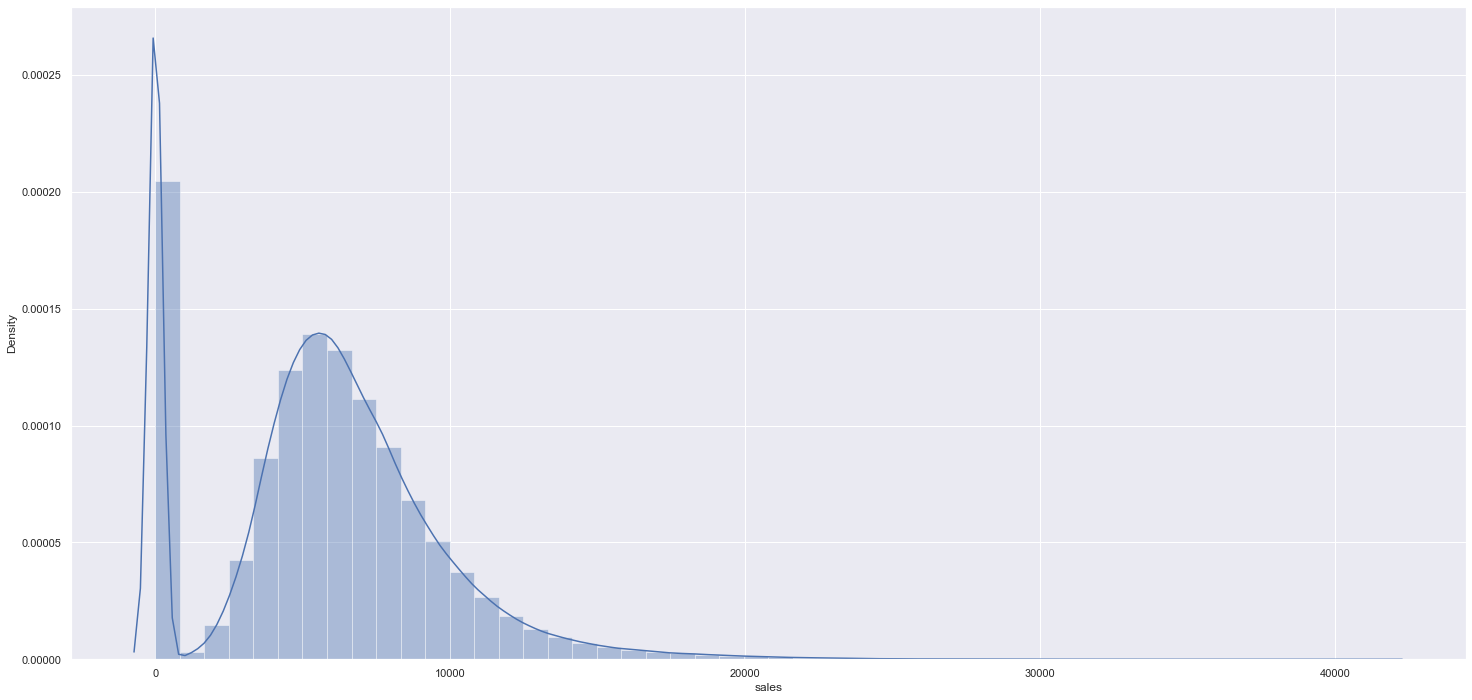

In [14]:
sns.distplot(df1['sales'])

## 1.7.2 Categorical Attributes

In [15]:
categorical_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

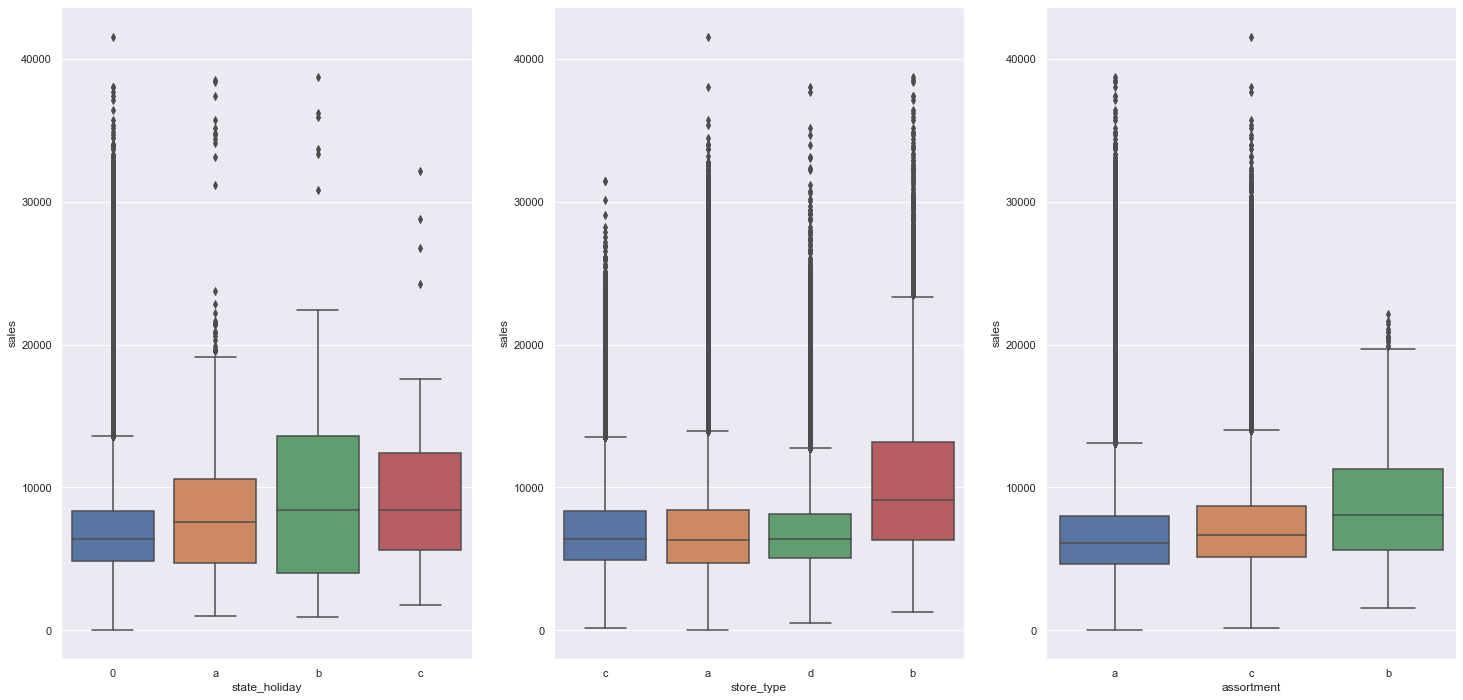

In [16]:
aux = df1[(df1['state_holiday'] != 0) & (df1['sales'] > 0)]
# sns.boxplot(x='state_holiday', y='sales', data=aux)

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux)

# 2.0. PASSO 2 - FEATURE ENGINEERING

In [17]:
df2 = df1.copy()

## 2.1. Criação das Hipóteses

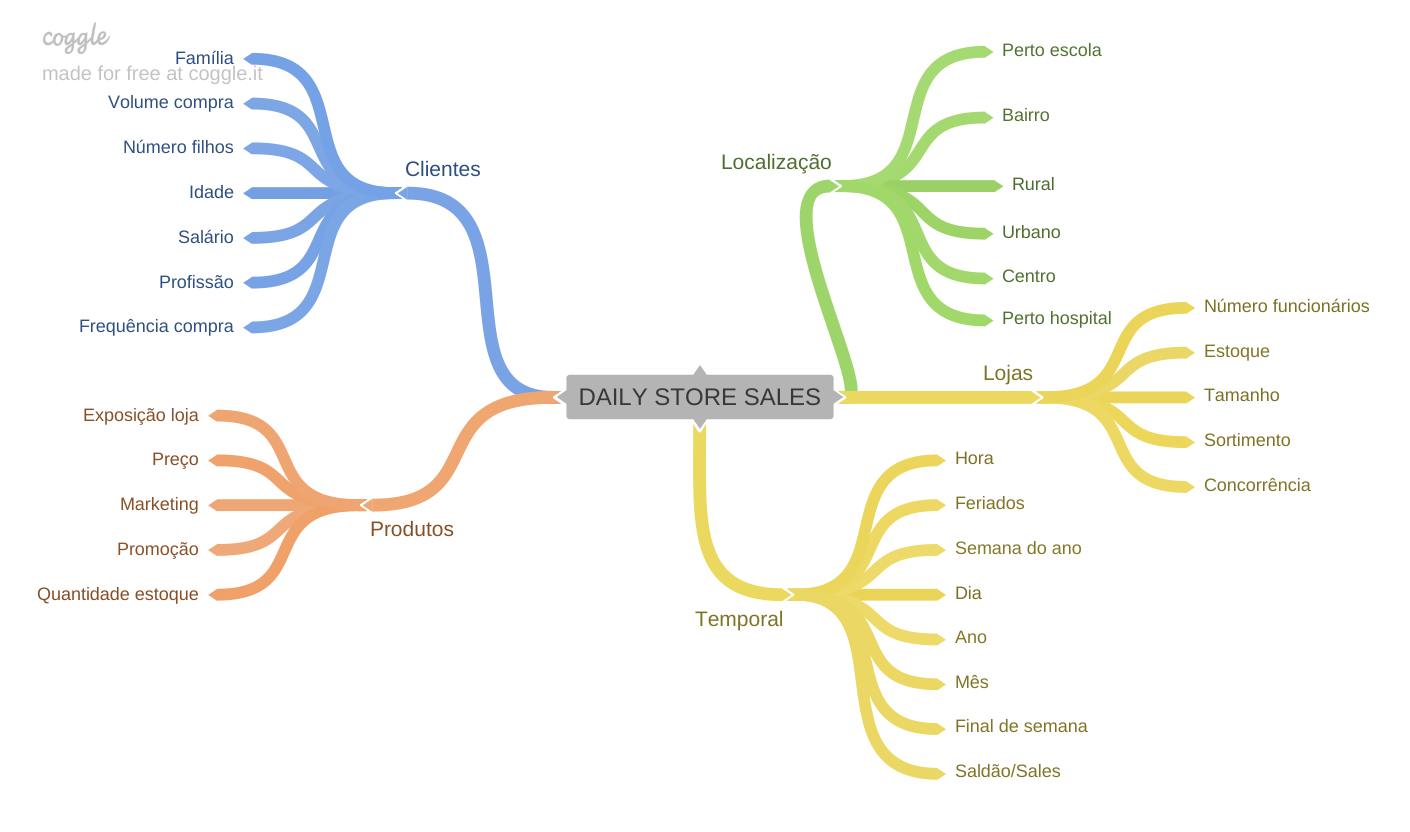

In [18]:
Image('../img/DAILY_STORE_SALES.png')

### 2.1.1. Hipóteses Loja

#### 1. Lojas com maior quadro de funcionários deveria vender mais
#### 2. Lojas com maior estoque deveriam vender mais
#### 3. Lojas com maior porte deveriam vender mais
#### 4. Lojas com menor porte deveriam vender menos
#### 5. Lojas com maior sortimento deveriam vender mais

### 2.1.2. Hipóteses Produto

#### 1. Lojas que investem mais em marketing deveriam vender mais
#### 2. Lojas que expõem mais os produtos nas vitrines deveriam vender mais
#### 3. Lojas que tem preços menores deveriam vender mais
#### 4. Lojas que tem preços menores por mais tempo deveriam vender mais
#### 5. Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais
#### 6. Lojas com promoções ativas por mais tempo deveriam vender mais
#### 7. Lojas com mais dias de promoção deveriam vender mais
#### 8. Lojas com mais promoções consecutivas deveriam vender mais

### 2.1.3. Hipóteses Tempo

#### 1. Lojas abertas durante o feriado de natal deveriam vender mais
#### 2. Lojas deveriam vender mais ao longo dos anos
#### 3. Lojas deveriam vender mais no segundo semestre
#### 4. Lojas deveriam vender mais depois do dia 10 de cada mês
#### 5. Lojas deveriam vender menos aos finais de semana
#### 6. Lojas deveriam vender menos durante os feriados escolares

## 2.2. Lista Final de Hipóteses

### 1. Lojas com maior sortimentos deveriam vender mais.
### 2. Lojas com competidores mais próximos deveriam vender menos.
### 3. Lojas com competidores à mais tempo deveriam vendem mais.
### 4. Lojas com promoções ativas por mais tempo deveriam vender mais.
### 5. Lojas com mais dias de promoção deveriam vender mais.
### 7. Lojas com mais promoções consecutivas deveriam vender mais.
### 8. Lojas abertas durante o feriado de Natal deveriam vender mais.
### 9. Lojas deveriam vender mais ao longo dos anos.
### 10. Lojas deveriam vender mais no segundo semestre do ano.
### 11. Lojas deveriam vender mais depois do dia 10 de cada mês.
### 12. Lojas deveriam vender menos aos finais de semana.
### 13. Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Feature Engineering

In [19]:
# year
df2["year"] = df2["date"].dt.year

# month
df2["month"] = df2["date"].dt.month

# day
df2["day"] = df2["date"].dt.day

# week of year
df2["week_of_year"] = df2["date"].dt.weekofyear

# year week
df2["year_week"] = df2["date"].dt.strftime("%Y-%W")

C:\Users\Baby\AppData\Local\Temp\ipykernel_2204\3277222297.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2["week_of_year"] = df2["date"].dt.weekofyear


In [20]:
# competition since
df2["competition_since"] = df2.apply(
    lambda x: datetime.datetime(
        year = x["competition_open_since_year"],
        month = x["competition_open_since_month"],
        day = 1,
    ),
    axis=1,
)

df2["competition_time_month"] = (
    ((df2["date"] - df2["competition_since"]) / 30).apply(lambda x: x.days).astype(int)
)

# promo since
df2["promo_since"] = (
    df2["promo2_since_year"].astype(str) + "-" + df2["promo2_since_week"].astype(str)
)
df2["promo_since"] = df2["promo_since"].apply(
    lambda x: datetime.datetime.strptime(x + "-1", "%Y-%W-%w")
    - datetime.timedelta(days=7)
)
df2["promo_time_week"] = (
    ((df2["date"] - df2["promo_since"]) / 7).apply(lambda x: x.days).astype(int)
)

# assortment
df2["assortment"] = df2["assortment"].apply(
    lambda x: "basic" if x == "a" else "extra" if x == "b" else "extended"
)

# state holiday
df2["state_holiday"] = df2["state_holiday"].apply(
    lambda x: "public_holiday"
    if x == "a"
    else "easter_holiday"
    if x == "b"
    else "christmas"
    if x == "c"
    else "regular_day"
)

In [21]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. PASSO 3 - FILTRAGEM DE VARIÁVEIS

In [22]:
df3 = df2.copy()

## 3.1. Filtragem de linhas

In [23]:
# Apagar as linhas não utilizadas
df3 = df3[ (df3['open'] != 0) & (df3['sales'] > 0) ] 

## 3.2. Filtragem de colunas

In [24]:
# Apagar as colunas não utilizadas
drop_col = ['open', 'customers', 'promo_interval', 'month_map']
df3.drop(drop_col, inplace=True, axis=1)

# 4.0. PASSO 4 - ANÁLISE EXPLORATÓRIA DOS DADOS

In [25]:
df4 = df3.copy()

## 4.1. Análise Univariada

### 4.1.1. Variável Resposta

### 4.1.2. Variáveis Numéricas

### 4.1.3. Variáveis Categóricas

## 4.2. Análise Bivariada

## 4.3. Análise Multivariada